## 1  Finding entity classes in embeddings

In this notebook we're going to use embeddings to find entity classes and how they correlate with other things

In [36]:
%matplotlib inline


from sklearn import svm
from keras.utils import get_file
import os
import gensim
import numpy as np
import random
import requests
import geopandas as gpd
from IPython.core.pylabtools import figsize
import csv
figsize(12, 8)

In [3]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

## 3.4　在词嵌入中发现实体类

在样本集和国家样本集上使用支持向量机（SVM）。  
例如，让我们查找Word2vec空间中的国家。我们从再次加载模型开始，搜索与德国这个国家类似的事物：

In [4]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)
model.most_similar(positive=['Germany'])

[('Austria', 0.7461061477661133),
 ('German', 0.7178748846054077),
 ('Germans', 0.6628647446632385),
 ('Switzerland', 0.6506868004798889),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437495946884155),
 ('Cologne', 0.6430779099464417),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.6342949271202087)]

In [5]:
model.most_similar(positive=['Annita_Kirsten'])

[('Braustolz_GmbH', 0.7545095086097717),
 ('DIARY_Economic_Indicators', 0.7334568500518799),
 ('##-##_#####_Burscheid', 0.7307888269424438),
 ('WKN_A#N#Y#_Symbol', 0.7260339260101318),
 ('Hoevelaken', 0.7067490220069885),
 ('BMW_###si_1min_##.###secs', 0.7050350904464722),
 ('Primera_EUROPE', 0.699741005897522),
 ('symbol_RSTI', 0.6925467252731323),
 ('Severin_Freund', 0.6898956894874573),
 ('However_Joern_Lauterjung', 0.6885738968849182)]

No we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [6]:
countries = list(csv.DictReader(open('../data/countries.csv')))
countries[:10]

[{'name': 'Canada', 'cc': 'ca', 'cc3': 'can'},
 {'name': 'Turkmenistan', 'cc': 'tm', 'cc3': 'tkm'},
 {'name': 'Ethiopia', 'cc': 'et', 'cc3': 'eth'},
 {'name': 'Swaziland', 'cc': 'sz', 'cc3': 'swz'},
 {'name': 'Czech_Republic', 'cc': 'cz', 'cc3': 'cze'},
 {'name': 'Cameroon', 'cc': 'cm', 'cc3': 'cmr'},
 {'name': 'UAE', 'cc': 'ae', 'cc3': 'are'},
 {'name': 'Liberia', 'cc': 'lr', 'cc3': 'lbr'},
 {'name': 'Netherlands', 'cc': 'nl', 'cc3': 'nld'},
 {'name': 'East_Timor', 'cc': 'tl', 'cc3': 'tls'}]

In [7]:
positive = [x['name'] for x in random.sample(countries, 40)]
negative = random.sample(model.index_to_key, 5000)
negative[:4]

['TRADERS_ABANDON_SHIP', 'Coid', 'ODE_TO', 'Canadian_Adverse_Reaction']

In [8]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

((5040, 300), (5040,))

In [9]:
TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off]) 

SVC(kernel='linear')

In [10]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.85827664399093,
 [('Slovaks', 0),
  ('Baltics', 0),
  ('Iran', 1),
  ('poorest_continent', 0),
  ('Caicos', 0)])

现在，我们可以在全部单词上执行分类器来抽取国家：

In [11]:
all_predictions = clf.predict(model.vectors)

In [13]:
res = []
for word, pred in zip(model.index_to_key, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

['Portugal',
 'Cambodia',
 'Tunisia',
 'Sudan',
 'Hong_Kong',
 'Vietnam',
 'Romania',
 'Kosovo',
 'UAE',
 'Philippine']

## 3.5　计算类内部的语义距离

给定一个类，例如国家，我们可以以一定的标准通过查找相对的距离来对该类的成员进行排序：

In [14]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(184, 300)

In [17]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.544024
New_Zealand 3.9619699
Finland 3.9392407
Puerto_Rico 3.838145
Jamaica 3.8102932
Sweden 3.8042789
Slovakia 3.703874
Australia 3.671101
Bahamas 3.6240416
United_States 3.5374339


In [19]:
dists.shape

(184,)

In [20]:
dists_all = np.dot(country_vecs, country_vecs.T)

In [27]:
for idx in reversed(np.argsort(dists_all[country_to_idx['Canada']])[-10:]):
    print(countries[idx]['name'], dists_all[country_to_idx['Canada']][idx])

Canada 7.5440216
New_Zealand 3.9619699
Finland 3.93924
Puerto_Rico 3.838145
Jamaica 3.8102937
Sweden 3.8042793
Slovakia 3.7038746
Australia 3.6711018
Bahamas 3.6240418
United_States 3.5374339


对一组国家的任意词语做一些排名。对于每个国家，我们将计算国家名称和想要排序的词语之间的距离。与该词语“更接近”的国家与这个词语更相关：

In [29]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx]))
            for idx in reversed(np.argsort(dists)[-topn:])]

In [30]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.192489147186279),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162838459014893),
 ('Barbados', 3.757995128631592),
 ('India', 3.7504398822784424),
 ('South_Africa', 3.6561501026153564),
 ('New_Zealand', 3.642028570175171),
 ('Fiji', 3.608567714691162)]

## 3.6　在地图上可视化国家数据

GeoPandas是一个在地图上可视化数值数据的完美工具。  
这个不错的库把Pandas的能力和地理原语结合起来，并且预装了几张地图。  
让我们加载世界地图：

In [31]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [34]:
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

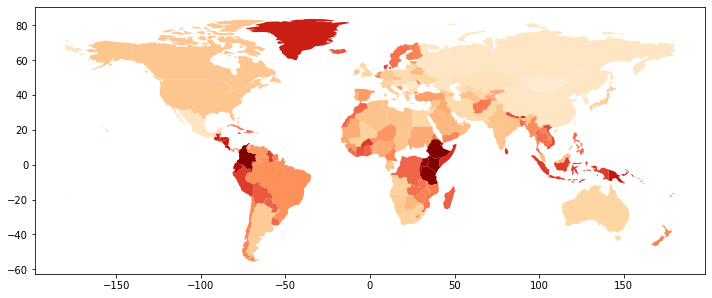

In [37]:
map_term('coffee')

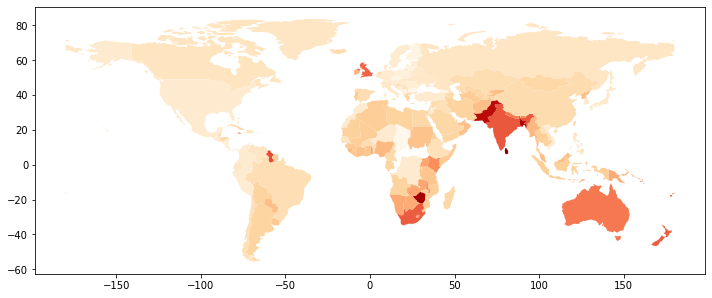

In [38]:
map_term('cricket')

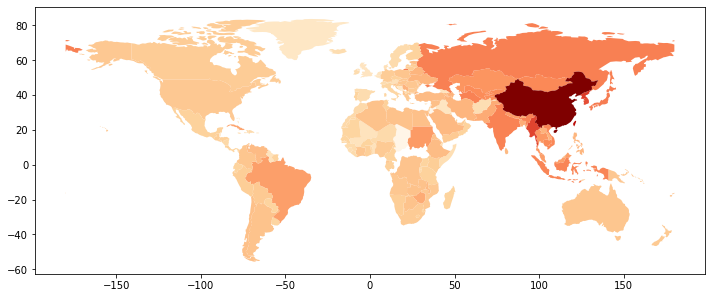

In [39]:
map_term('China')

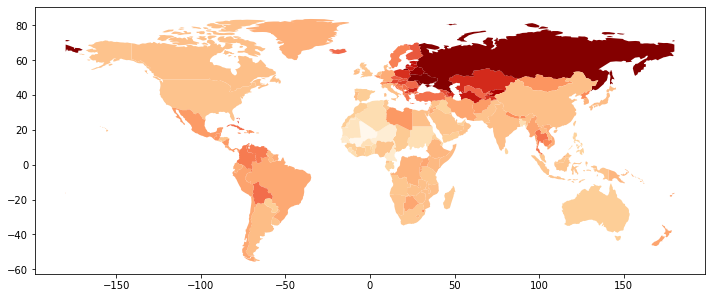

In [40]:
map_term('vodka')

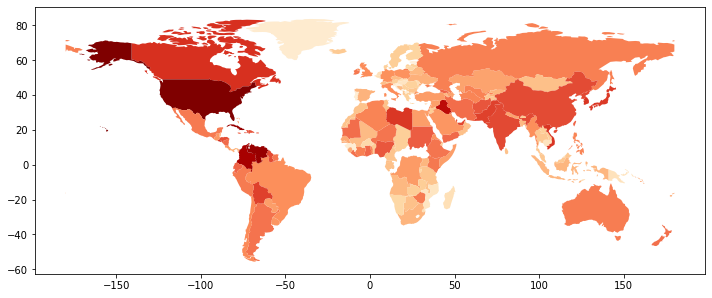

In [43]:
map_term('American')